# Assignment 1 -- ML4F 2021 -- Group 04

David Landveld - 2742120 - d.j.f.landveld@student.vu.nl

Mark de Kwaasteniet - 2649271 - m.g.de.kwaasteniet@student.vu.nl

Marc van Gils - 2703225 - m.p.van.gils@student.vu.nl

### Modules

We will also run a reset to make sure that no dataframes, variables, and packages are stored from previous commands.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from math import sqrt

## Introduction

According to Wikipedia, the definition of a stock is: 
“Stock (also capital stock) is all of the shares into which ownership of a corporation is divided. In American English, the shares are collectively known as "stock". A single share of the stock represents fractional ownership of the corporation in proportion to the total number of shares.”
Some people trade with these stocks. But when is it worth to buy such one? What influence the prices of those stocks? In this assignment you will predict whether a stock is worth to buy or not. 
There are a lot of variables to choose from. The goal is to predict the column ‘class’. This is an indicator whether to buy the stock in the next period or not. 




Let's load and have a look at the data. We set the stock name as the index of the dataframe to provide a more structured view of the dataframe.

In [2]:
path = os.path.join('data','stocks.xlsx')

df_data = pd.read_excel(path)
df_data = df_data.rename(columns={"Unnamed: 0": "Stock"})
df_data = df_data.set_index(['Stock'])

##### Interpretation of Dataframe
We see that the dataframe contains large, zero and NaN values. We assume that all the variables in the dataframe should contain positive values. For example, it is not possible to have negative Income Tax Expense because in that case you would receive Tax, which is not possible. 

This means that the only variable that could be negative is the Revenue Growth. It could be a decrease or an increase in %. We have therefore decided to manipulate the variable Revenue Growth directly. We add a constant to the Revenue Growth in order to make sure that every value is positive. If there are still negative values in the Revenue Growth, we consider them to be incorrect values, since it is not possible to have a decrease in Revenue larger than 100%.

In [3]:
df_data['Revenue Growth'] = df_data['Revenue Growth'] + 1

## Preparation

Before we start the analysis, we prepare the data by labelling them correctly and splitting into targets and features.

In [4]:
target_name = 'Class'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

# The features are considered all the dataframe variables expect Class.
sr_features = df_data.drop([target_name] ,axis=1)


# Question 1
(30 points)


### *As you learned in the lectures, preprocessing the data set is an important set to use machine learning models. Why is this important?*

#### Answer:
With pre-processing data we consider transforming and manipulating the data to make it more appropriate for the models that we will specificy later in the assignment.

This so-called pre-processing input data is considered important because the algorithms used in Machine Learning, like a (logistic) regression or Support Vector Machines, work better and/or faster when the considered features are on a similar scale and/or normally distributed. Since we often use a lot of different features in our dataset, the features tend to have different sizes and scales. In order to run the algorithms in the proposed way, we should make sure that all these features have similar scales to prevent one feature from significantly impacting the model because of its disproportionate magnitude. 

An example is the following. If you would have a feature with values like 10 grams and a feature with values like 10 euro's, it will treat both features the same, even though the measure of both features are completely different. However, for the algorithm the numbers are just the same. 

It is also important because pre-processing is used to adress non-linearity or heterogeneity and it improves the numerical stability of the data. This, for example, can be done by normalization and standardization. Normalizing and standardizing makes sure that the data can be used in estimations and that we can assign the correct weights to the different parameters that will help us make a proper prediction.

### *Use the methods discussed in ML2 to preprocess the data. Make descriptive statistics and histograms etc to find out more about the distributions of the data. Discuss your output: are there outliers etc? Then choose what preprocessing to apply.*


First, the data is examined using descriptive statistics and plots to determine the distributions.
#### Descriptive Statistics

In [5]:
df_data.describe()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Class
count,3.761000e+03,3.572000e+03,3.734000e+03,3.756000e+03,3.672000e+03,3.749000e+03,3.741000e+03,3.753000e+03,3.745000e+03,3.728000e+03,3.742000e+03,3808.000000
mean,3.918622e+18,-2.819193e+03,3.700973e+09,2.188214e+09,9.401830e+07,9.307406e+08,-5.999198e+26,6.748248e+08,1.002018e+08,5.725866e+08,1.762750e+08,0.429097
std,2.398954e+20,1.673319e+05,3.040688e+10,1.159028e+10,6.408912e+08,4.820928e+09,7.031507e+28,3.786291e+09,6.991091e+08,2.793740e+09,1.011342e+09,0.495012
min,-6.276160e+08,-1.000000e+07,-5.455740e+08,-1.105000e+09,-1.500000e+05,0.000000e+00,-3.948300e+30,-6.786000e+09,-2.250000e+08,-8.878000e+09,-2.081114e+09,0.000000
25%,5.793000e+07,9.976500e-01,3.135714e+06,3.092900e+07,0.000000e+00,1.548900e+07,3.106600e+07,-1.308000e+06,0.000000e+00,-3.732902e+06,0.000000e+00,0.000000
50%,4.385430e+08,1.061850e+00,1.414420e+08,1.908760e+08,0.000000e+00,7.381800e+07,1.386820e+08,4.104400e+07,2.563000e+06,2.842700e+07,5.335000e+06,0.000000
75%,2.395500e+09,1.188875e+00,1.199844e+09,8.922534e+08,9.911000e+06,3.510000e+08,5.885100e+08,2.712980e+08,4.300000e+07,2.193835e+08,5.752550e+07,1.000000
max,1.471205e+22,4.213966e+04,1.537249e+12,4.621600e+11,1.153700e+10,1.856830e+11,1.704000e+30,1.565540e+11,3.152300e+10,8.720500e+10,3.970800e+10,1.000000


To start, the descriptive statistics show that every feature has multiple missing values that need to be taken into account. The table also shows that various features have one or more negative values. We assume that these negative values represent incorrect values since it does not make sense to have negative Cost of Revenue for example (as explained in 'interpretation of dataframe'). Furthermore, it shows that multiple features have large differences between the minimum and maximum value, indicating possible outliers. These are not treated right away since the data will be plotted first. Another observation is that the average of class is < 0.5. This shows us that there are more zeros in the dataset than there are ones.
#### Histograms
We cannot easily interpret the histograms without pre-processing the data. Right now the histograms are represented with one single large bar that includes more than 3500 observations. The reason for these distributions could be both the scale and the outliers of the features themselves. Therefore, the histograms will be included in a later stage when they show up in an interpretable way. 

#### Balancedness
We see that the classifier is somewhat imbalanced. This could have several impacts for our model and model performance. Therefore, we will tackle the impact of this imbalancedness later on when evaluating the model.

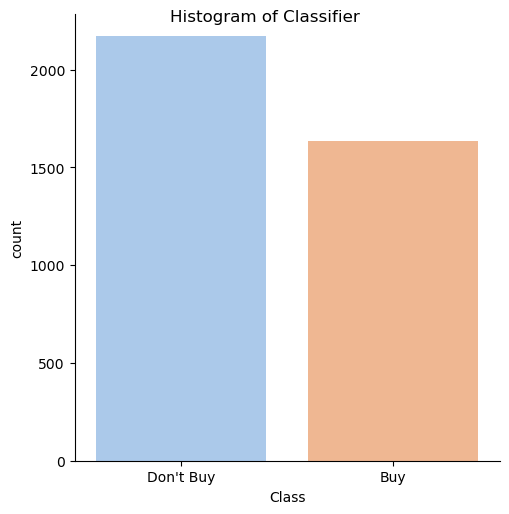

In [6]:
# Creating histogram with the target using seaborn package. 
g_class = sns.catplot(x=target_name, kind="count", palette="pastel", data=df_data)
g_class.set_xticklabels(["Don't Buy", "Buy"])
g_class.fig.suptitle('Histogram of Classifier')
plt.show()

#### Boxplots of the data
The following boxplots are created for every feature using the seaborn package in python. These boxplots show that every feature has one or more outliers, some with more extreme outliers than others. This is also in line with what we expected from the histogram.

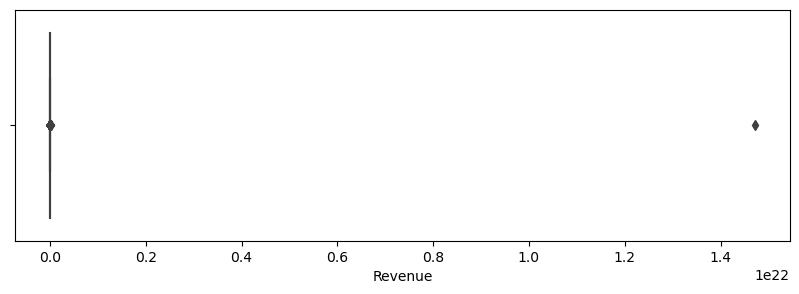

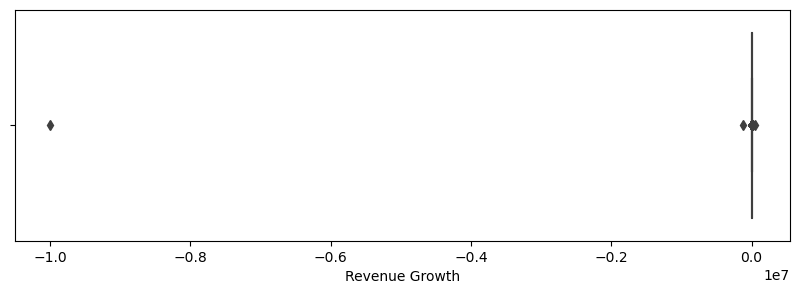

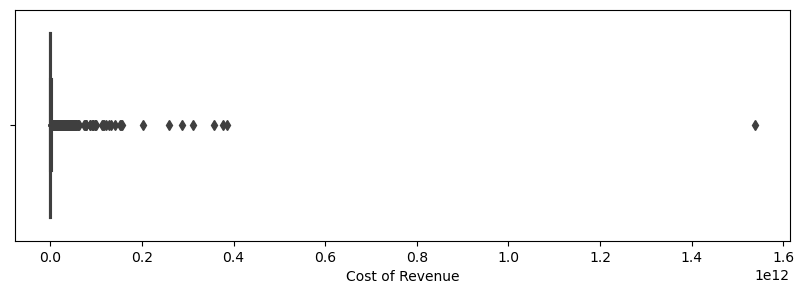

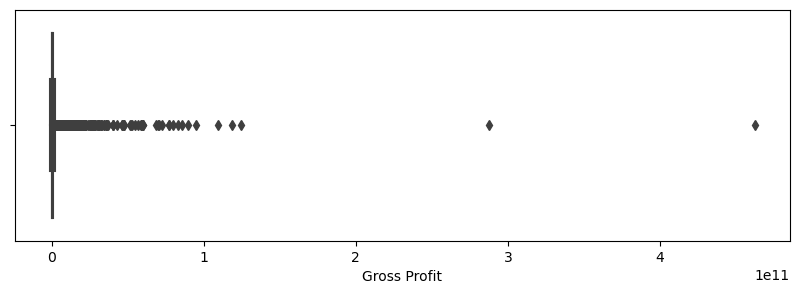

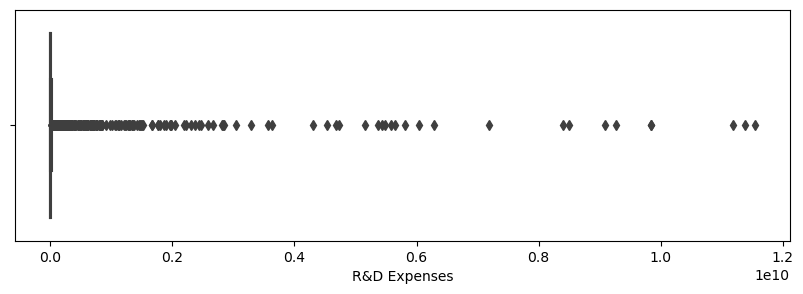

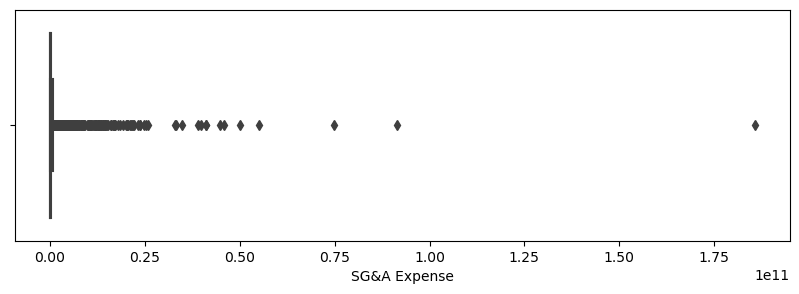

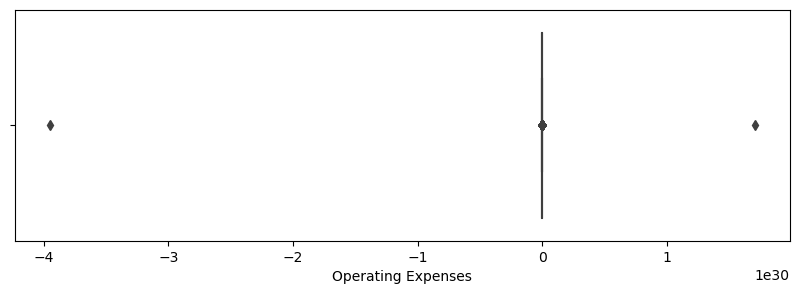

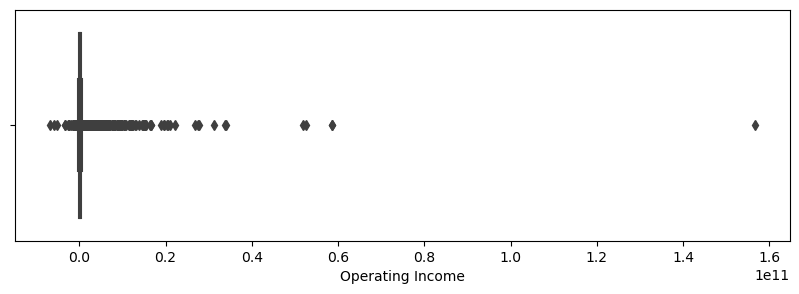

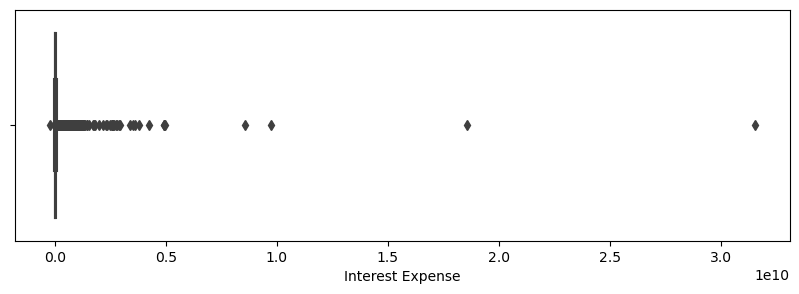

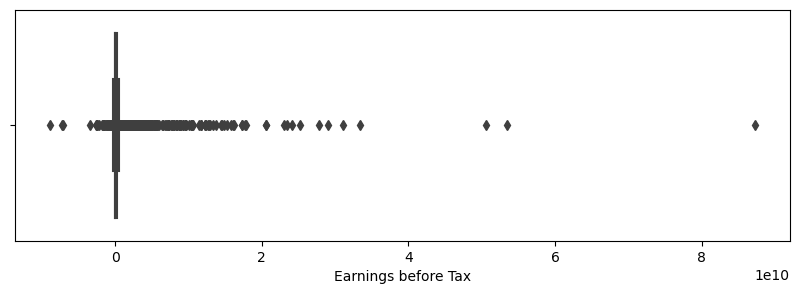

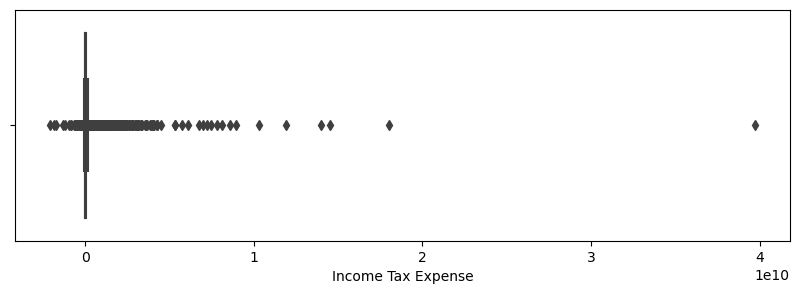

In [7]:
#Loop over all features and create boxplot for every feature
for columns in sr_features:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 3)
    sns.boxplot(x=sr_features[columns])
    plt.show()

#### Transforming the features
In order to have useful features for the analysis, we would need extra steps to pre-process the features. Our aim is to make the distributions of the features more similar to normal distributions.
1. First of all, we tried to clip the freatures by first removing the outliers at the 1 and 99 percentile. 
This turned out to be inefficient, resulting in similar distributions as before with only the x-axis being slightly reduced to a smaller number.
2. Secondly, we tranformed every feature using a log tranformation.

#### Log Transformation
The log tranformation has three aspects of which we were interested in. 
1. The log transformation is a very usefull tranformation method on positively skewed data distritubions. In our case, most of the features have positive skewness, looking at the earlier histograms or calculated with $Skewness = \frac{3* (Mean – Median)}{Standard\ Deviation}$
2. The log transformation decreases the scale of the distribution. Since we are working with very large numbers in the features, this aspect is very usefull for plotting the histograms. The distributions will become more normally distributed.
3. The log transformation automatically creates NaN/Missing values from the negative values in the features. It is not possible to take the logarithm of a negative value, therefore it will return NaN. In our case this is perfect, because we consider the negative values in the features to be incorrect. This is another reason why the Revenue Growth feature that initially could be negative, was changed into a feature that could only be positive. 

By taking the log of every feature, we had to determine what to do with the zero's in the features. Some features have a lot of zero's, for example the feature: R&D Expenses. This means that around 2400 companies in the initial dataframe did not have any Research and Development Expenses. Taking the log of 0, will return infinite, meaning we had to come up with a representable value. 

We decided to let these zero's return to NaN (instead of zero) after the log tranformation. The reason behind this:
1. This will create a more normally distributed feature
2. (Primary Reason) Later on we want to predict the 'Class' with, for example, an increase/decrease in R&D Expenses. 

If we would let these zero's return to zero, the coefficient for these features would be biased if a lot of values in this feature are equal to zero. It creates a big gap between no R&D expenses (zero) and some R&D expenses (not zero). 

However, we are aware that this will extract/drop a lot of the companies (rows) in the features that are selected for the logistic regression model but also have a large amount of zeros in it. ***We will address this issue and provide a solution later in the assignment at Feature Engineering.***

In [8]:
#Using numpy log to take the log of the whole dataframe, replacing the zero's/infinites by NaN
log_sr_features = (np.log(sr_features)).replace(-np.inf, np.nan)

#### Histograms
Looking at the histograms of the features after the log transformation, the features seem to be (more) normally distributed than before. However, we still acknowledge some outliers. These may not be similar to the incorrect values that were filtered out using the log transformation, but they could still mess up the predictions since they are extreme values that don't happen frequently. We don't want our algorithm to emphasize too much on these values, because this would mess up our predictions in the test set later on. Therefore, we decided to remove these outliers from the features using Z-scores.
#### Robust Standardization
By standardizing, every feature will have similar scales making it easier to compare the features. Furthermore, after the standardization, a certain percentile of the data can be easily removed using the standard deviation that is calculated. We choose standardization over normalization, because standardization provides more usefull info about the outliers in the dataframe (which is asked in the question).
 
In our case we use the RobustScaler of scikit, since it is more robust against outliers compared to the StandardScaler, meaning it scales the features according to the InterQuartileRange (0.25|0.75) of that feature. 

However, since this method is not immune to outliers, we still find some outliers in the histograms after the standardization. We want remove these outliers to improve the generalisability of the logistic model that we are specifying later on. 

We clip these outliers ourselves using 4 standard deviations relative to every feature. Meaning we replace all the values that are outside 0.1% and 99.99% of the distribution of a certain feature by NaN. We set them to NaN instead of winsorizing, to prevent certain features from having a large number of -4 and/or 4 values (especially Revenue Growth).


In [9]:
STD_OUTLIER = 4

df_robust_std = log_sr_features.copy()

#Standardize using RobustScaler
df_robust_std[df_robust_std.columns] = RobustScaler().fit_transform(df_robust_std[df_robust_std.columns])

#Convert values in the dataframe with a z-score < -4 or > 4 to NaN
df_robust_std[(df_robust_std < -STD_OUTLIER) | (df_robust_std > STD_OUTLIER)] = np.nan


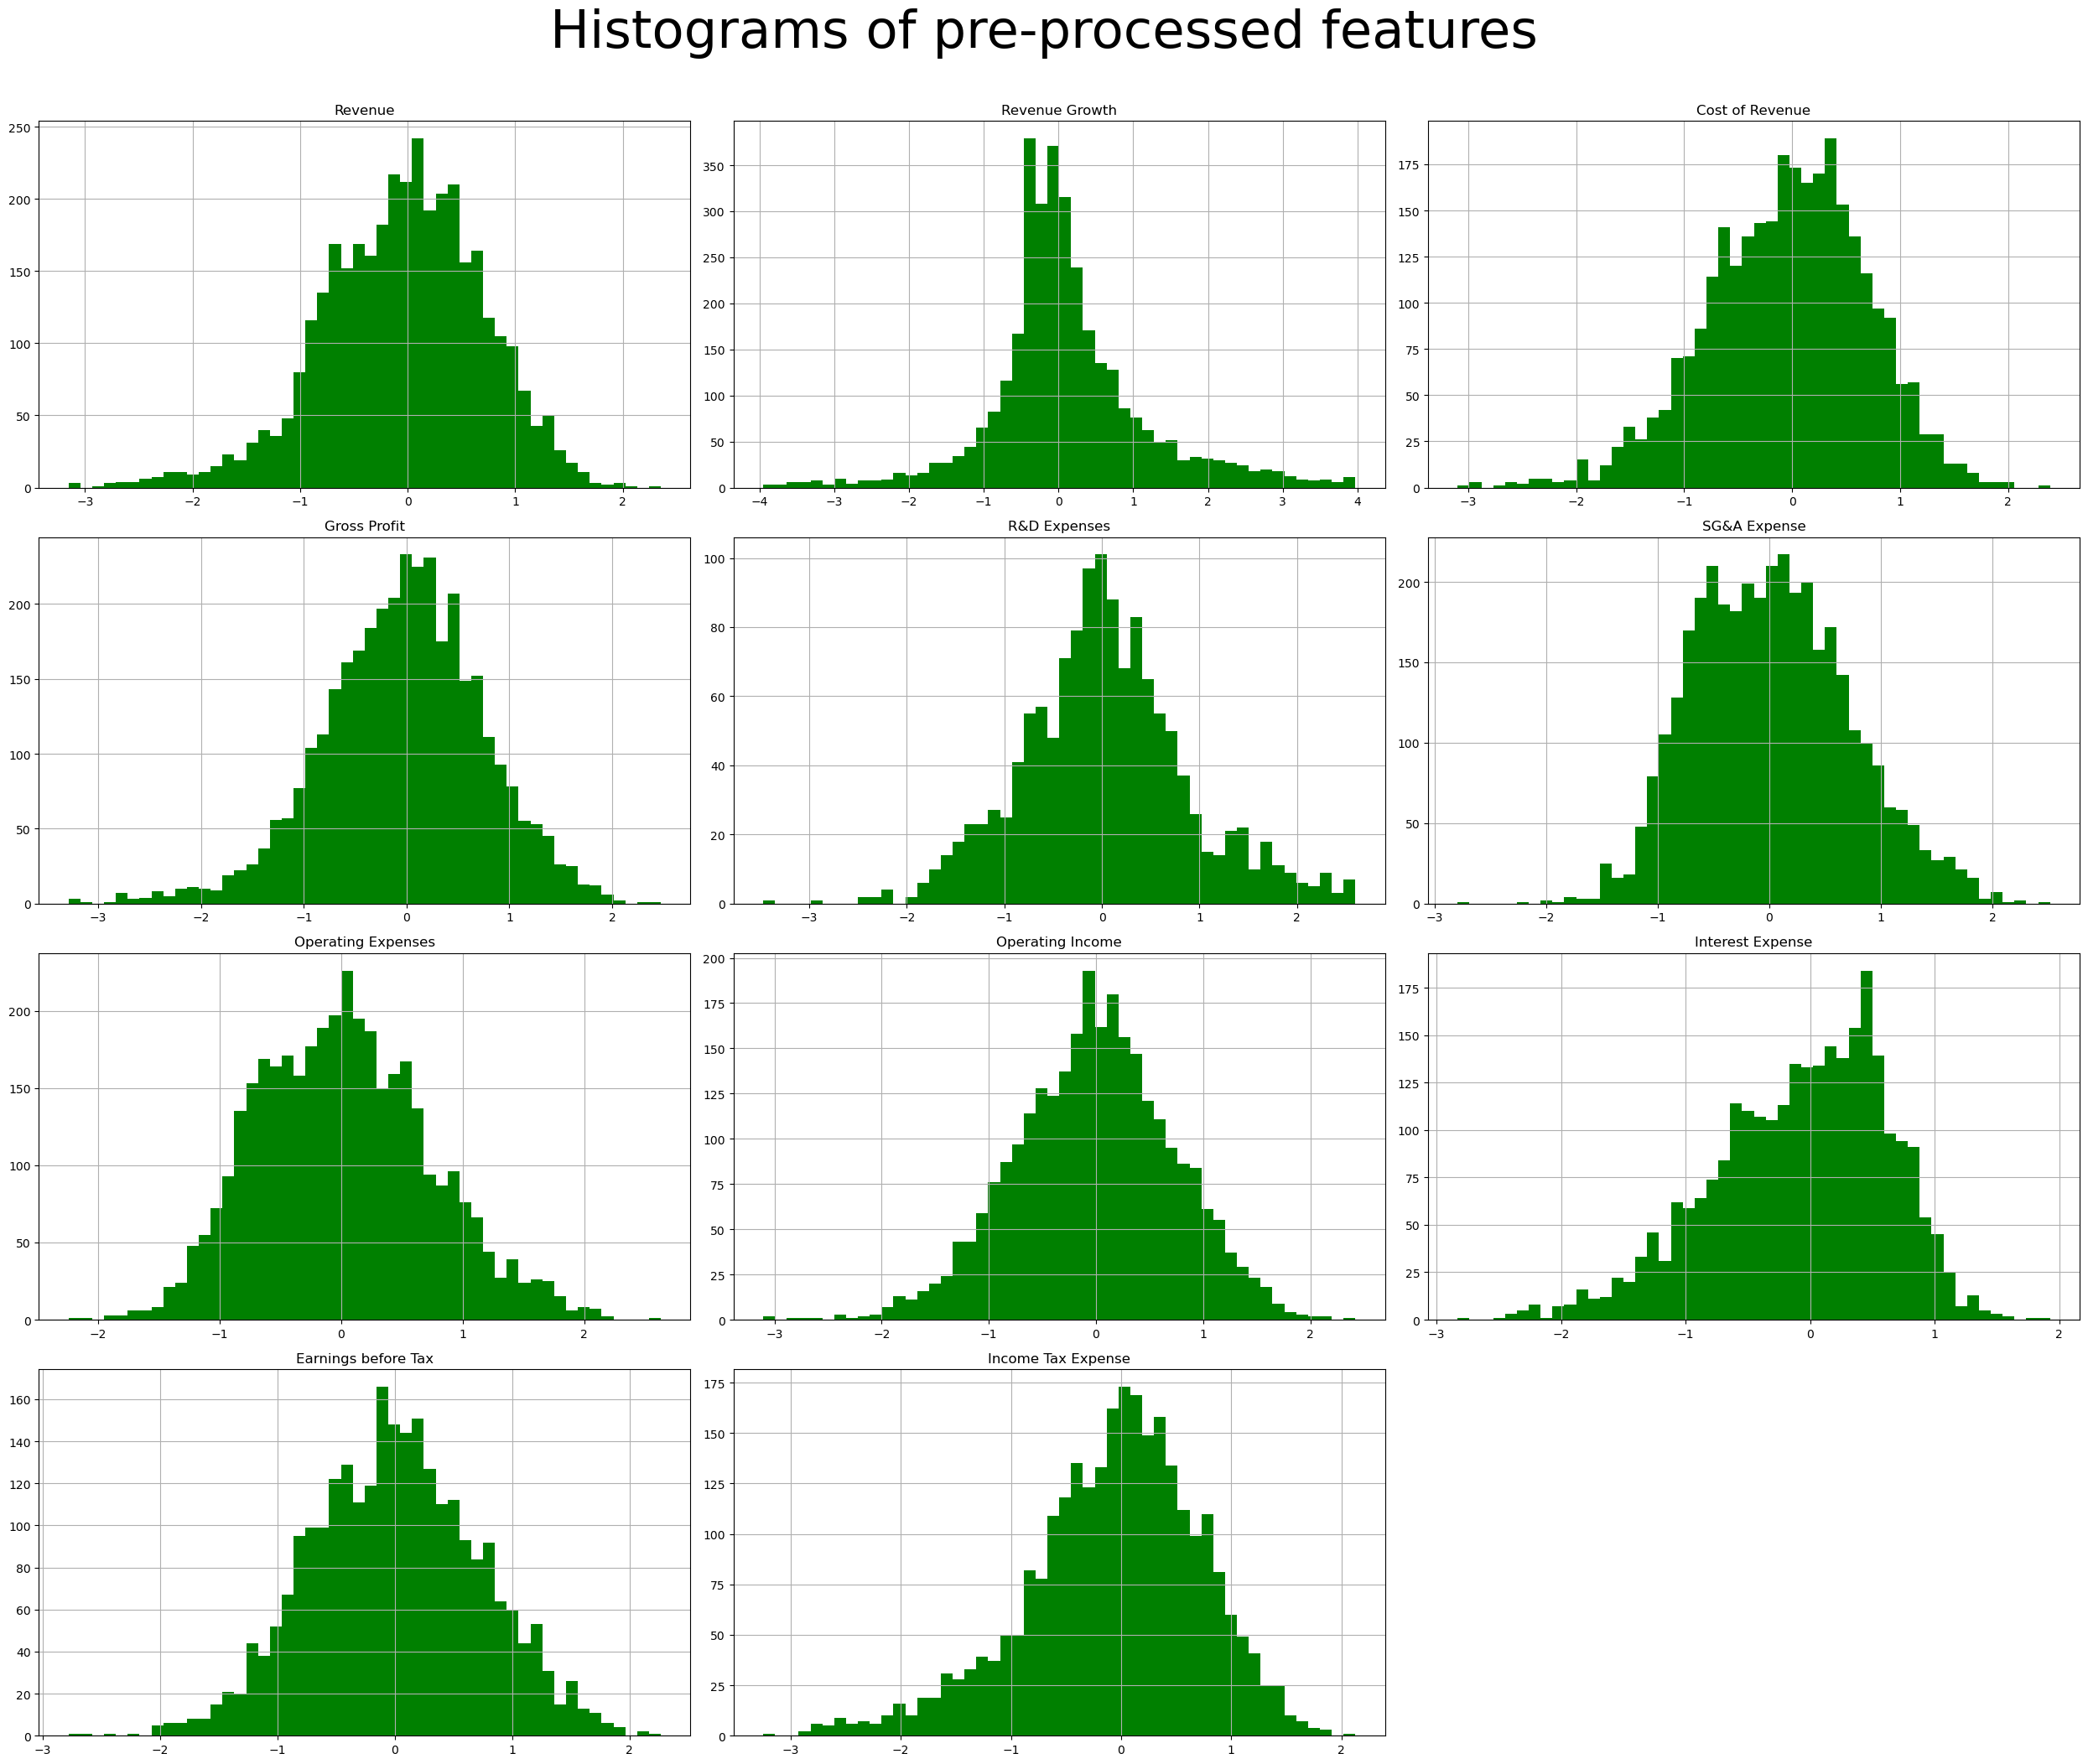

In [10]:
df_robust_std.hist(bins=50, figsize=(25, 20), color = "g")
plt.tight_layout()   

plt.suptitle('Histograms of pre-processed features', x=0.5, y=1.05, ha='center', fontsize='45')
plt.show()



When we look at the histograms above we see that the pre-processing efforts resulted in normal distributed data. As explained before, to run the algorithms in the proposed way all features should have similar scales to prevent one feature from significantly impacting the model. This is now the case and will be particularly useful when we run the logit regression during a later stage.

### *Which features will you use to make your predictions? Looking at a correlation matrix might help: df_date.corr gives a correlation matrix of the dataframe. Other feature selection approaches are also fine. Explain your choices.*

#### Features Selection Method 1:
In order to determine which features should be selected to make predictions, a heatmap is created using the seaborn package with a correlation matrix of all the features in the dataframe plus the target 'Class'.

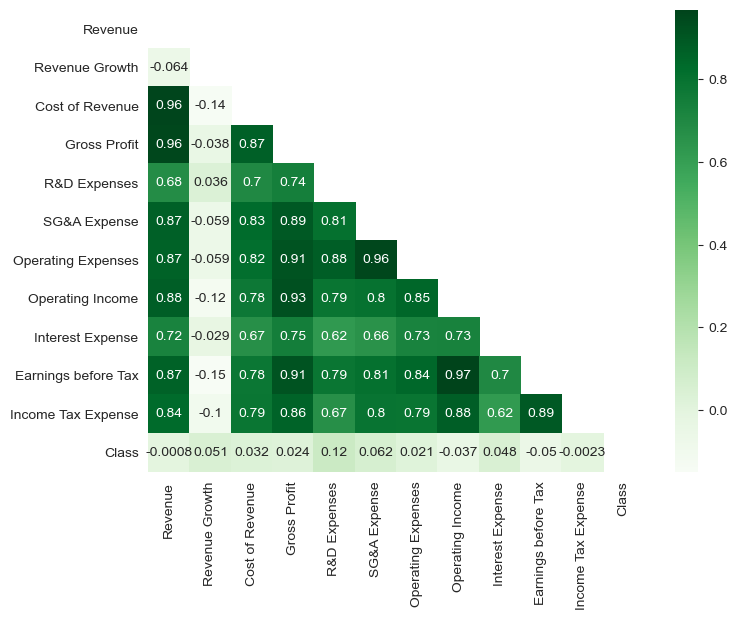

In [11]:
#Creating a heatmap of the correlation matrix, including the target (Class)
df_robust_std[target_name] = sr_targets

plt.figure(figsize=(8,6))
sns.set_style(style='white')

# Calculate the correlations between the features and store only upper side.
correlations = df_robust_std.corr()
matrix = np.triu(correlations)

sns.heatmap(correlations, annot=True, cmap=plt.cm.Greens, mask = matrix)
plt.show()


The correlation that we calculated is not designed for dealing with categorical variables, because often the categorical variables have no notion of mean. Since, our categorical variable (the classifier) is only binary, we can consider it as a continuous variable and determine the correlation for feature selection.

In [12]:
#Create a list of the correlation between the features and the target.
cor_target = abs(correlations[target_name])
relevant_features = cor_target
relevant_features.sort_values(ascending =False)

Class                  1.000000
R&D Expenses           0.115930
SG&A Expense           0.061567
Revenue Growth         0.051008
Earnings before Tax    0.049555
Interest Expense       0.048260
Operating Income       0.037357
Cost of Revenue        0.032491
Gross Profit           0.023860
Operating Expenses     0.020701
Income Tax Expense     0.002315
Revenue                0.000798
Name: Class, dtype: float64

Here, we see that the features R&D Expenses and SG&A Expense have the highest correlation with the target. This would suggest that we would take these features into consideration with our logistic regression. However, an assumption of the logistic regression model is that there is absence of multicollinearity. Meaning that the explanatory variables, in this case the features R&D Expenses and SG&A Expense should not be correlated with each other. Looking at the heat map, we clearly see a high correlation (0.96) between the two features, indicating that we should not use them both in the logistic regression, since it will affect the performance of the model predictions. 

Revenue Growth is another feature for the logistic regression as it is almost as correlated with the target as SG&A Expense.

The other features will not be taken into account for the estimation of the logistic regression model. These feature have a lower correlation with the classifier compared to R&D Expenses. Furthermore, they could violate the multicollinearity assumption of the logistic regression model. 

#### Feature Selection Method 2:
Another method to determine which features to use is using the Variance Threshold. If features don't really change with regard to their values, it means they have a low variance. It is unlikely that they hold good prediction power over the target since they do not change much. For this, we need to determine what the variance threshold will be for the data. Looking at the data, we already see that all the features have similar variances. Some are much higher than others, like Revenue Growth and R&D Expenses, which could therefore be more predictive over the target. This is in line with the correlation matrix of method 1.

In [13]:
df_robust_std.iloc[:,:-1].var().sort_values(ascending=False)

Revenue Growth         1.129307
R&D Expenses           0.746184
Income Tax Expense     0.640200
Gross Profit           0.609348
Revenue                0.562405
Cost of Revenue        0.551100
Operating Income       0.549864
Earnings before Tax    0.527100
Operating Expenses     0.502416
Interest Expense       0.496701
SG&A Expense           0.484388
dtype: float64

### *Why should you make a training and a test set?* 

A training set is used to train the model with selected features (specified in this assignment). This means that this model uses the corresponding data of these features in the training set to learn what characteristics a stock should posess to get a 1 or 0 (to be bought or not to be bought). When the model is trained, it is tested on the test set to check whether it has provided good predictions of the target using completely new input values (which is the test set). The model will be robust if it performs well during testing.

### *Make a training and test set. Describe briefly what parameters these sets have: how many observations in both sets?*

We will work with two seperate dataframes.
1. A DataFrame that contains only the target values of every company. 
2. A DataFrame that contains two features, R&D Expenses and Revenue Growth. These were selected based on their correlation with the target and each other. Since the feature R&D Expenses, initially contained a lot of zero expenses, the companies that have missing values in this feature are dropped from the dataframe.

For splitting the dataset in a training and test set, we use the 80/20 rule. This means we select 80% of our dataframe for training the model and 20% of our dataframe for testing the model.

In [14]:
#Select features to include in the model
sr_rbst_features = df_robust_std[['R&D Expenses','Revenue Growth',target_name]]

#Drop the rows/companies that have missing values in 'R&D Expenses' or 'Revenue Growth'.
sr_rbst_features = sr_rbst_features.dropna()
#Later on we will impute the missing values. 

sr_rbst_targets = sr_rbst_features[target_name]
sr_rbst_features = sr_rbst_features.drop([target_name], axis=1)


In [15]:
SPLIT_SIZE = 0.2
COSTANT_SPLIT = 0

#Construct train and test set and target using sklearn. Using a random state of 0, to produce the same training and test sets.
features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=SPLIT_SIZE, random_state=COSTANT_SPLIT)


# Question 2
(10 points)

### *Estimate a Logistic regression model with the target variable 'class'. Use the User Guide of Scikit-learn for the syntax and the training set of the previous question. What are the estimated coefficients?*

Since this dataset contains only thousands of companies, it is considered a small dataset. We, therefore, use a logistic regression with the LibLinear solver since LibLinear is considered a good solver for small datasets without multiple classifiers. 

Using the LibLinear solver, we are able to perform two penalty methods. There are two types of regularization, which avoids overfitting when training a model. 
1. L1 regularization is called Lasso 
2. L2 regularization is called Ridge Regression. 

For both techniques, a regularization parameter is added to the cost function in order to shrink the weights. The Lasso technique is a form of feature selection since it tries to reduce overfitting by shrinking some features to 0. In the Ridge Regression technique, the weights are also shrinked but only towards a small value if the features would be less significant for the predictions to be made. 

As a consequence, due to our previous (manual) feature selection process, the Ridge regression technique is used in the logistic regression.

In [16]:
REG_RIDGE = 'l2'
LIBLIN = 'liblinear'
ROUND = 2

# Run a logistic regression using Ridge Regression and the LibLinear solver
clf = LogisticRegression(penalty=REG_RIDGE, solver=LIBLIN).fit(features_train, targets_train)

# Print the coefficients of the logistic regression model.
print('The coefficient of R&D Expense is ' + str(round(clf.coef_[0][0],ROUND)))
print('The coefficient of Revenue Growth is ' + str(round(clf.coef_[0][1],ROUND)))
print('The coefficient of Intercept is ' + str(round(clf.intercept_[0],ROUND)))


The coefficient of R&D Expense is 0.33
The coefficient of Revenue Growth is 0.18
The coefficient of Intercept is -0.51


Since the model is a logisitic regression model, we can only interpret the signs of the coefficients and not the magnitude. This means that both R&D expenses and Revenue Growth have a positive influence on the probability of buying a stock. 

The expected mean of the Class is -0.51, if both the R&D Expenses and Revenue Growth are equal to zero. 

# Question 3
(30 points)

### *Make predictions for the test set.*

The Area Under the ROC curve is 0.5145


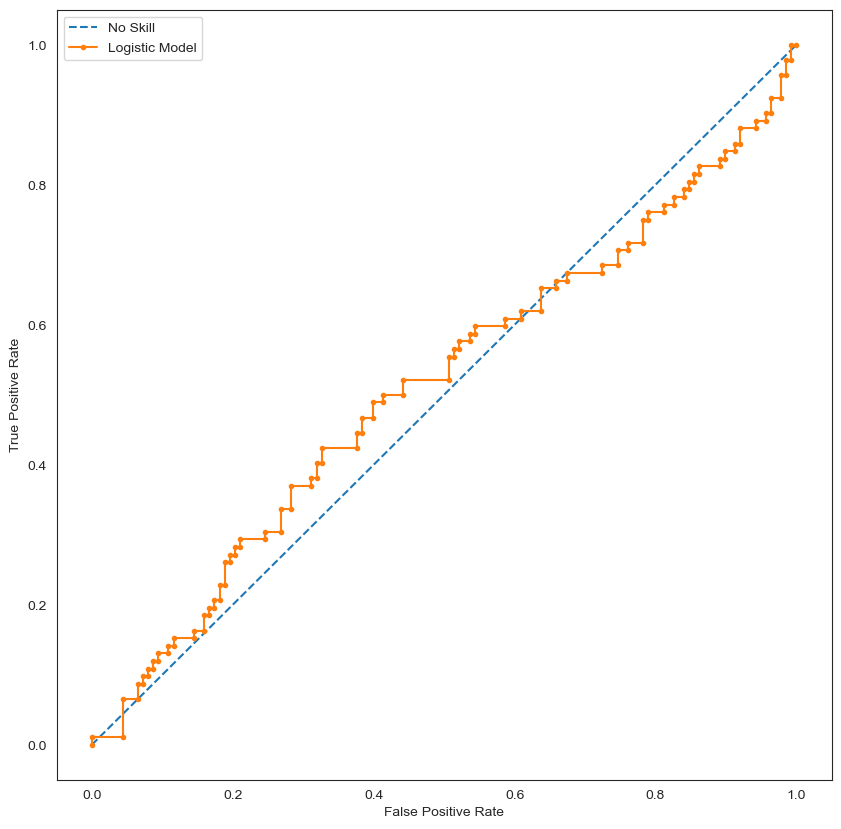

In [17]:
plt.figure(figsize=(10,10))
ns_probs = [0 for _ in range(len(targets_test))]
# fit a model
# predict probabilities
lr_probs = clf.predict_proba(features_test)
targets_pred = clf.predict(features_test)

print('The Area Under the ROC curve is ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(targets_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(targets_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

### *Discuss the results in terms of investment advice: would you put your money on your algorithm?*

Looking at both the ROC Curve and the AUROC, we see that the ROC curve is very similar to the No Skill (AUROC 0.5) curve. The area under the ROC curve is 0.5145. This value means that the logistic model predicts only slightly better than a random guess. 

Therefore, in terms of investment advice, the algorithm does not have strong prediction power. We would not put our money in the algorithm. 

### *Feature engineering can also be helpful to make better predictions. Define at least 2 new features with the features given in the dataset.* 

With Feature Engineering we use combinations or characteristics of the features and categorize them as new features to increase the predictability of the features in the model.
We are introducing the following new features/methods to our dataset:
1. Dummy variables for the values that we have assumed to be zero. Earlier, we decided to drop the rows if a company for example had no R&D Expenses. This means that, until now, we only worked with companies that had R&D Expenses and that the dataset for the logistic regression (r =1146) was considerably smaller than the raw dataset (r=3808). Therefore, these dummy variables will be included into the dataframe and have a value of zero if the company has no R&D expenses and 1 if the company has R&D Expenses. The same goes for the Interest Expense, Income Tax Expense and Cost of Revenue features.


2. Gross Profit Margin. A profitability ratio is included for every company. Which is constructed using the following formula: $Gross\ Profit\ Margin = \frac{Revenue\ -\ Cost\ of\ Revenue}{Revenue}$


3. After including all the new additional features. We scale (min-max) the whole dataframe to make sure that every feature is in the same scale for creating an optimal logistic regression.


4. As mentioned earlier, we also have to come up with a solution for the missing values (at R&D Expenses, Interest Expense, etc) by filling them with the mean of the corresponding feature. After normalizing the whole dataset every feature with NaN values will therefore be filled in by a zero, since all the features are normally distributed.


In [18]:
# Creation of new dummy and profitability variables using the raw features dataset
sr_features['R&D_Dummy'] = (sr_features['R&D Expenses'] > 0).astype(int)
sr_features['Interest_Dummy'] = (sr_features['Interest Expense'] > 0).astype(int)
sr_features['Tax_Dummy'] = (sr_features['Income Tax Expense'] > 0).astype(int)
sr_features['Cost_Revenue_Dummy'] = (sr_features['Cost of Revenue'] > 0).astype(int)
sr_features['Gross_Profit_Margin'] = (sr_features['Revenue'] - sr_features['Cost of Revenue'])/sr_features['Revenue']

# Manipulate the profitability variable in terms of NaN and Inf.
sr_features['Gross_Profit_Margin']= sr_features['Gross_Profit_Margin'].replace([np.inf, -np.inf], np.nan)
sr_features[sr_features['Gross_Profit_Margin'] < 0] = np.nan

# Log transform the variable to scale it similarly to the other numerical features. Where the negative values will return nan 
sr_features['Gross_Profit_Margin'] = (np.log(sr_features['Gross_Profit_Margin'])).replace(-np.inf, np.nan)


#### Normalizing the whole dataframe

In [19]:
#Combining the robust standardized features with the newly created features from above.
sr_rbst_features_dum = df_robust_std.join(sr_features.iloc[:,11:])

#Scale the dataframe, using the following formula to work with NaN values
sr_norm_features=(sr_rbst_features_dum-sr_rbst_features_dum.min())/(sr_rbst_features_dum.max()-sr_rbst_features_dum.min())


### *Use the new features and rerun the classification. Do the new features improve the predictions? Is it possible that it does worse? Please explain.*

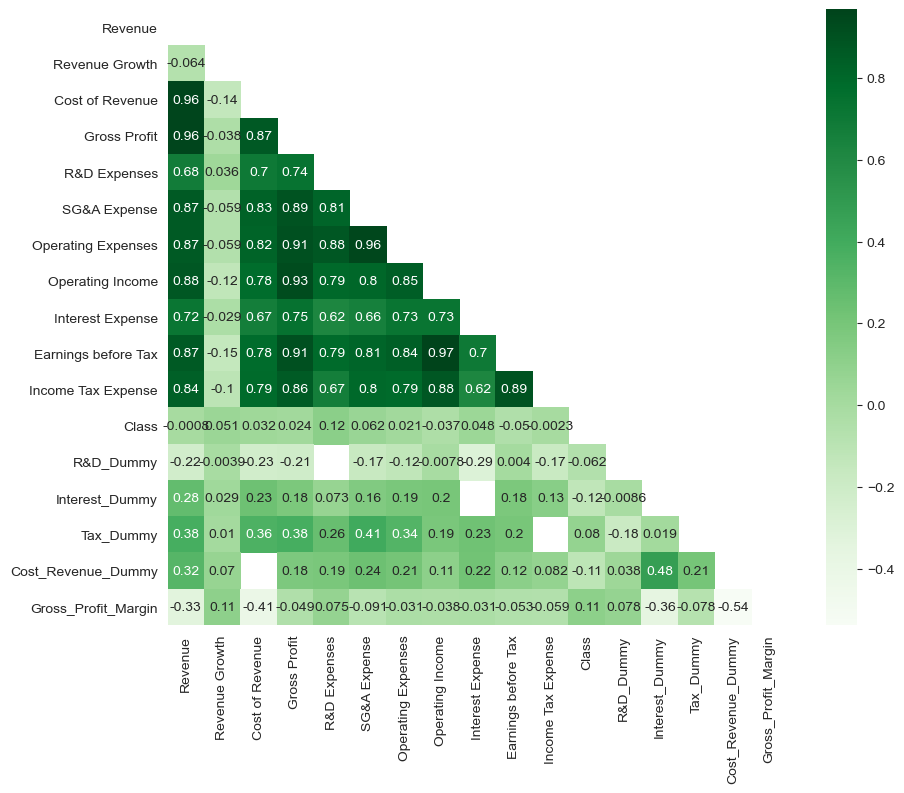

In [20]:
#Updated correlation matrix - with new features

sr_norm_features[target_name] = sr_targets
plt.figure(figsize=(10,8))

#correaltion matrix - keeping only the upper side of the matrix
correlations = sr_norm_features.corr()
matrix = np.triu(correlations)

sns.heatmap(correlations, annot=True, cmap=plt.cm.Greens, mask=matrix)
plt.show()

In [21]:
#Updated features with a correlation > 0.1
cor_target = abs(correlations[target_name])
relevant_features = cor_target[cor_target>0.1]
relevant_features.sort_values(ascending =False)

Class                  1.000000
Interest_Dummy         0.121493
R&D Expenses           0.115930
Gross_Profit_Margin    0.112409
Cost_Revenue_Dummy     0.109824
Name: Class, dtype: float64

Here we will only select the features that have a correlation with the classifier of 0.1 or higher, to keep the logistic regression model as parsimonious as possible.

In [22]:
sr_rbst_features = sr_norm_features[relevant_features.index]

#Filling in the mean for all NaN values
sr_rbst_features = sr_rbst_features.fillna(sr_rbst_features.mean())

sr_rbst_targets = sr_rbst_features[target_name]
sr_rbst_features = sr_rbst_features.drop([target_name], axis=1)

# Split new sets with new features
features_train,features_test,targets_train,targets_test=train_test_split(sr_rbst_features,sr_rbst_targets,test_size=0.2,random_state=0)

# Run Logistic Regression again
clf = LogisticRegression(penalty=REG_RIDGE, solver=LIBLIN).fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('AUROC: ' + str(round(roc_auc_score(targets_test,targets_pred),4)))

AUROC: 0.5765


By implementing the steps of feature engineering, we are able to improve the AUROC only slightly (from .5145 to .5765). Although it is a minor improvement, the improvement is there. While testing different combinations of features, it has come to our attention that it is also possible that feature engineering causes worse results regarding the correlation and variance. This, however, did not affect our results since we filter on both. 

To conclude, using the process of feature engineering would make us slightly more comfortable to put money in this algorithm.

# Question 4
(10 points)

### *Run the same model as in the previous question but set the tolerance for stopping criteria on 0.01 instead of the default one of 1e-4. Discuss these results in relation to the default: what is different? Why?*

In [23]:
ROUND = 4
TOL = 0.01

#Run a regression with tolerance level of 0.01
clf = LogisticRegression(penalty=REG_RIDGE, solver=LIBLIN, tol=TOL).fit(features_train, targets_train)
targets_pred = clf.predict(features_test)
print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),ROUND)))
print('The Area Under the ROC curve is : ' + str(round(roc_auc_score(targets_test,targets_pred),ROUND)))

Accuracy of the model: 0.6168
The Area Under the ROC curve is : 0.5765


In [24]:
#Run a regression with a default tolerance level
clf = LogisticRegression(solver=LIBLIN, penalty=REG_RIDGE).fit(features_train, targets_train)
targets_pred = clf.predict(features_test)

print('Accuracy of the model: ' + str(round(clf.score(features_test,targets_test),ROUND)))
print('The Area Under the ROC curve is : ' + str(round(roc_auc_score(targets_test,targets_pred),ROUND)))

Accuracy of the model: 0.6168
The Area Under the ROC curve is : 0.5765


The tolerance level tells scikit to stop searching for a minimum (or maximum) once this tolerance is achieved, i.e. once you're close enough. As can be seen above, using a tolerance level of 0.01, the solver has found the same AUROC. Using the default method, it results in the same AUROC compared to when we use the tolerance level of 0.01.

This is surprising because we would expect a higher AUROC for the default tolerance. Since, it is the threshold for when the solver should stop searching for the maximum likelihood. Meaning that if we set this threshold higher, the solver will finish more quickly because it stops earlier with searching for the maximum likelihood. This ***could*** therefore result in a lower AUROC and accuracy (which corresponds to the outcome above). 

However, this phenomenon clearly will not hold for every different test and training set and different tolerance level.

# Question 5
(20 points)

### *Compute the confusion matrix of the model estimated in Question 4.* 
### *Compute precision and recall for this case.*

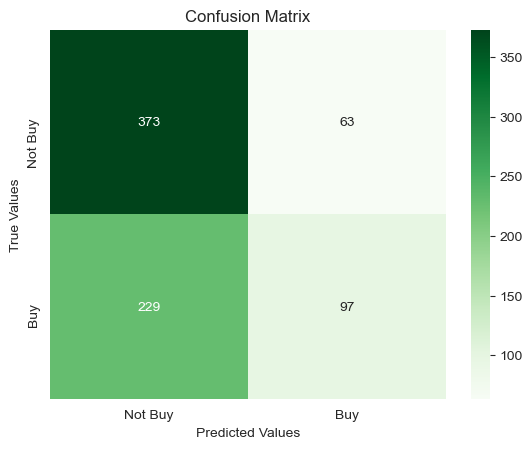

In [25]:
confusion_m = confusion_matrix(targets_test, targets_pred)

ax= plt.subplot()
sns.heatmap(confusion_m, annot=True, fmt='g', ax=ax, cmap=plt.cm.Greens);

# labels, title and ticks
ax.set_xlabel('Predicted Values');ax.set_ylabel('True Values'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Buy', 'Buy']); ax.yaxis.set_ticklabels(['Not Buy', 'Buy']);
plt.show()

In [26]:
print(classification_report(targets_test, targets_pred))

              precision    recall  f1-score   support

           0       0.62      0.86      0.72       436
           1       0.61      0.30      0.40       326

    accuracy                           0.62       762
   macro avg       0.61      0.58      0.56       762
weighted avg       0.61      0.62      0.58       762



### *Interpret the confusion matrix. Pay attention to whether your dataset is balanced and the costs of various outcomes (e.g. FP, TP etc.).*

The dataset provided with this assignment has been divided into features and targets. As we have seen before, the mean of the targets (with a value of either 0 or 1) leaned more towards 0. This means that we have an imbalanced dataset with regard to classification. As a result, the model will have a biased accuracy since more 0s are in the dataset. Therefore, the accuracy measure is possibly misleading.

63 are positively predicted but are actually negative (false positive). 229 are actually positive but are negatively predicted (false negative).

The precision, which are the true positives divided by the total positives, is almost similar for predicting the Not Buying (0) and predicting the Buying. Meaning the algorithm is performing the same in creating relevant predictions for class 0 compared to class 1. 

Next to this, the recall is much higher for not to buy (class 0) compared to to buy (class 1). This means that the algorithm better classifies that you shouldn't buy in comparison to that you should buy the stock. Recall, of all the zero's how many are really zero. This is better for zero's compared to ones. Because of all the one, it only has 30% right.

When we look at the confusion matrix we see that the model predicts a lot more false negatives than false positives. This means that the model predicts more 0s where 1s are the actual values. 

---